In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics.pairwise import cosine_similarity

# Model Definition
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=1)

In [2]:
# Client Class
class Client:
    def __init__(self, id, train_data, test_data, is_mal=False, target=7):
        self.id = id
        self.train_data = train_data
        self.test_data = test_data
        self.is_malicious = is_mal
        self.target = target
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def add_trigger(self, img):
        img = deepcopy(img)
        h, w = img.shape[1:]
        x, y = np.random.randint(2, w-3), np.random.randint(2, h-3)
        img[0, y:y+2, x-2:x+2] = 1.0  # Simple square trigger
        img[0, y-2:y+2, x:x+2] = 1.0
        return img
    
    def train(self, model, epochs=1):
        model.train().to(self.device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
        
        # Poison 50% of data if malicious
        dataset = [(self.add_trigger(x), self.target) if self.is_malicious and np.random.rand() < 0.5 
                   else (x, y) for x, y in self.train_data]
        
        loader = DataLoader(dataset, batch_size=32, shuffle=True)
        for _ in range(epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                loss = F.nll_loss(model(x), y)
                loss.backward()
                optimizer.step()
        return {k: v.cpu().clone() for k, v in model.state_dict().items()}


In [3]:
# Server Class with Multiple Defenses
class Server:
    def __init__(self, model, clients, defense='foolsgold'):
        self.model = model
        self.clients = clients
        self.defense = defense
        self.mal_ids = [c.id for c in clients if c.is_malicious]
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
    def aggregate(self, updates):
        if self.defense == 'foolsgold':
            return self.foolsgold(updates)
        elif self.defense == 'mudhog':
            return self.mudhog(updates)
        elif self.defense == 'contra':
            return self.contra(updates)
        return self.simple_avg(updates)
    
    def foolsgold(self, updates):
        vecs = [torch.cat([p.flatten() for p in u.values()]).cpu().numpy() for u in updates]
        sims = cosine_similarity(vecs)
        n = len(updates)
        np.fill_diagonal(sims, -np.inf)  # Ignore self-similarity
        max_sims = np.max(sims, axis=1)
        weights = np.ones(n)
        weights[max_sims > 0.9] = 0
        if np.sum(weights) == 0:
            weights = np.ones(n)
        return weights / weights.sum()
    
    def mudhog(self, updates):
        vecs = [np.histogram(torch.cat([p.flatten() for p in u.values()]).cpu().numpy(), bins=20)[0] 
                for u in updates]
        dists = np.array([np.linalg.norm(v - np.mean(vecs, axis=0)) for v in vecs])
        weights = 1 / (1 + dists)
        return weights / weights.sum()
    
    def contra(self, updates):
        vecs = np.array([torch.cat([p.flatten() for p in u.values()]).cpu().numpy() for u in updates])
        centroid = np.mean(vecs, axis=0)
        sims = cosine_similarity(vecs, centroid.reshape(1, -1))
        return sims / sims.sum()
    
    def simple_avg(self, updates):
        return np.ones(len(updates)) / len(updates)
    
    def evaluate_backdoor(self):
        success = 0
        for client in self.clients:
            if client.is_malicious:
                x, _ = next(iter(DataLoader(client.test_data, batch_size=1)))
                poisoned = client.add_trigger(x[0]).unsqueeze(0).to(self.device)
                success += (self.model(poisoned).argmax() == client.target).item()
        return success / len(self.mal_ids) * 100 if self.mal_ids else 0


In [7]:
# Experiment Runner
def run_experiment(num_clients=20, mal_percent=0.2, defense='foolsgold', rounds=5):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Prepare data
    train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10('./data', train=False, transform=transform)
    client_data = random_split(train_data, [len(train_data)//num_clients]*num_clients)
    
    # Create clients
    num_mal = int(num_clients * mal_percent)
    clients = [Client(i, client_data[i], test_data, i<num_mal) for i in range(num_clients)]
    
    # Train
    server = Server(CIFAR10CNN(), clients, defense)
    success_rates = []
    for _ in range(rounds):
        updates = [client.train(server.model) for client in clients]
        weights = server.aggregate(updates)
        new_state = {k: sum(u[k]*w for u, w in zip(updates, weights)) 
                     for k in updates[0].keys()}
        server.model.load_state_dict(new_state)
        server.model.to(server.device)  # Ensure model stays on correct device
        success_rates.append(server.evaluate_backdoor())
    
    return np.mean(success_rates[-3:])  # Last 3 rounds average



In [8]:
# Plotting Function
def plot_results(results):
    defenses = ['foolsgold', 'mudhog', 'contra']
    percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    
    plt.figure(figsize=(10, 6))
    for defense in defenses:
        rates = [results[defense][p] for p in percentages]
        plt.plot([p*100 for p in percentages], rates, marker='o', label=defense.capitalize())
    
    plt.title('Backdoor Success Rate by Defense Mechanism')
    plt.xlabel('Percentage of Malicious Clients (%)')
    plt.ylabel('Attack Success Rate (%)')
    plt.xticks([10, 20, 30, 40, 50])
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('defense_comparison.png')
    plt.show()


Running foolsgold with 10% malicious clients...
Files already downloaded and verified
Running foolsgold with 20% malicious clients...
Files already downloaded and verified
Running foolsgold with 30% malicious clients...
Files already downloaded and verified
Running foolsgold with 40% malicious clients...
Files already downloaded and verified
Running foolsgold with 50% malicious clients...
Files already downloaded and verified
Running mudhog with 10% malicious clients...
Files already downloaded and verified
Running mudhog with 20% malicious clients...
Files already downloaded and verified
Running mudhog with 30% malicious clients...
Files already downloaded and verified
Running mudhog with 40% malicious clients...
Files already downloaded and verified
Running mudhog with 50% malicious clients...
Files already downloaded and verified
Running contra with 10% malicious clients...
Files already downloaded and verified


/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: Deprecatio

Running contra with 20% malicious clients...
Files already downloaded and verified


/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: Deprecatio

Running contra with 30% malicious clients...
Files already downloaded and verified


/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: Deprecatio

Running contra with 40% malicious clients...
Files already downloaded and verified


/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: Deprecatio

Running contra with 50% malicious clients...
Files already downloaded and verified


/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_state = {k: sum(u[k]*w for u, w in zip(updates, weights))
/tmp/ipykernel_5819/1202584638.py:23: Deprecatio

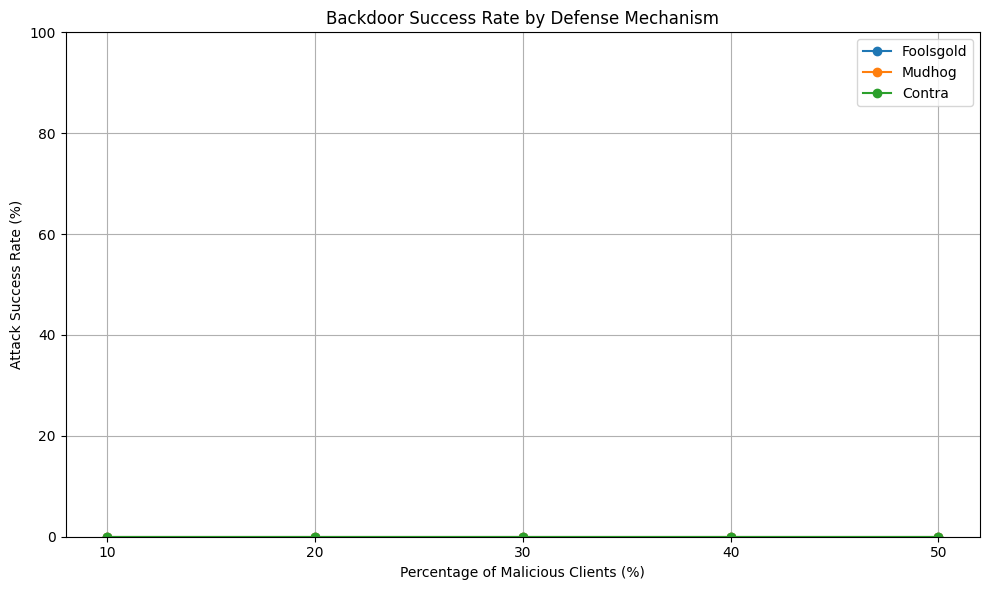

In [9]:
# Main Execution
if __name__ == '__main__':
    results = {defense: {} for defense in ['foolsgold', 'mudhog', 'contra']}
    
    for defense in results.keys():
        for perc in [0.1, 0.2, 0.3, 0.4, 0.5]:
            print(f'Running {defense} with {int(perc*100)}% malicious clients...')
            success = run_experiment(mal_percent=perc, defense=defense)
            results[defense][perc] = success
    
    plot_results(results)